<a href="https://colab.research.google.com/github/jeonyeohun/2020_2_DeepLearning_Application/blob/master/HW_5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import datetime

In [2]:
import torch
import torchvision            
import torch.nn as nn

print(torch.__version__)

1.7.0+cu101


In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
from torchvision import datasets
from torchvision import transforms

In [5]:
#import matplotlib

%matplotlib inline
from matplotlib.pyplot import imshow, imsave

In [6]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = CNN, DEVICE = cuda


In [7]:
# Downloading datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)
fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True)
Fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [8]:
# Clean up existing folders 
!rm -rf data/test data/train

# Create test, train and their sub directories
!mkdir -p data/test/{0..19} data/train/{0..19}

In [9]:
# Save mnist_train images
count = [0] * 10
for i in range(len(mnist_train)):
  if(count[mnist_train[i][1]] < 2000):
    mnist_train[i][0].save('data/train/{:d}/{:d}.jpg'.format(mnist_train[i][1], mnist_train[i][1]*2000 + count[mnist_train[i][1]]))
    count[mnist_train[i][1]] = count[mnist_train[i][1]] + 1

# Save fashion_train images
count = [0] * 10
for i in range(len(fashion_train)):
  if(count[fashion_train[i][1]] < 2000):
    fashion_train[i][0].save('data/train/{:d}/{:d}.jpg'.format(fashion_train[i][1]+10, (fashion_train[i][1]+10)*2000 + count[fashion_train[i][1]]))
    count[fashion_train[i][1]] = count[fashion_train[i][1]] + 1

# Save mnist_test images
count = [0] * 10
for i in range(len(mnist_test)):
  if(count[mnist_train[i][1]] < 1000):
    mnist_test[i][0].save('data/test/{:d}/{:d}.jpg'.format(mnist_test[i][1], mnist_test[i][1]*1000 + count[mnist_test[i][1]]))
    count[mnist_test[i][1]] = count[mnist_test[i][1]] + 1

# Save fashion_train images
count = [0] * 10
for i in range(len(Fashion_test)):
  if(count[Fashion_test[i][1]] < 1000):
    Fashion_test[i][0].save('data/test/{:d}/{:d}.jpg'.format(Fashion_test[i][1]+10, (Fashion_test[i][1]+10)*1000 + count[Fashion_test[i][1]]))
    count[Fashion_test[i][1]] = count[Fashion_test[i][1]] + 1




In [88]:
# define transform
trans = transforms.Compose([transforms.Resize((28, 28)),
                            transforms.ToTensor()])

In [89]:
# define custom dataset
import os
from PIL import Image

class MixedMnistDataset (Dataset):
  def __init__ (self, root_dir, train, transform):
    self.samples = []
    self.transform = transform
    if(train):
      self.data_dir = os.path.join(root_dir, 'train')
    else:
      self.data_dir = os.path.join(root_dir, 'test')

    for category in os.listdir(self.data_dir):
      cat_folder = os.listdir(os.path.join(self.data_dir, category))
      for img_name in cat_folder:
        self.samples.append({'image': os.path.join((os.path.join(self.data_dir, category)), img_name), 'label': int(category)})

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_path = self.samples[idx]['image']
    image = Image.open(img_path)
    image = self.transform(image)
    label = self.samples[idx]['label']

    #label = torch.FloatTensor(self.samples[idx]['label'])
    #sample = {'image' : image, 'label' : label}
    return image, label



In [125]:
# Create dataset
mixed_dataset_train = MixedMnistDataset(root_dir='data/', train=True, transform=trans)
mixed_dataset_test = MixedMnistDataset(root_dir='data/', train=False, transform=trans)

# Create dataloader df
train_loader = DataLoader(dataset=mixed_dataset_train, batch_size=512, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mixed_dataset_test, batch_size=100, shuffle=False, drop_last=False)

In [126]:
class HelloCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=20):
        super(HelloCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # (N, 1, 28, 28) N은 배치 사이즈
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # 항상 0 이상의 값이 나온다. ReLU를 이 이후에 적용하면 계산량이 더 적다

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )
        
        # 컨볼루션은 3차원이라서 바로 fully connected 로 넘어갈 수 없어서 별도의 sequential로 나눈다.
        
        self.fc = nn.Sequential(
            nn.Linear(3*3*512, 512), # 입력: 컨볼루션의 채널 * 인풋,  아웃풋 노드 수 : 512
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes), 
        )
        
    def forward(self, x):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1) # y_.size(0) : batch size, -1 : 자동 계산 -> 3차원 shape을 linear shape으로 바꾼다
        y_ = self.fc(y_) # shpae을 바꾼 뒤에 fully connected 로 넣는다
        return y_

In [127]:
model = HelloCNN().to(DEVICE)

In [128]:
# utility function to measure time

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [129]:
# set loss function and optimizer

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [130]:
# reset loss history
all_losses = []

In [131]:
max_epoch = 50        # maximum number of epochs
step = 0             # initialize step counter variable

plot_every = 100
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        
        y_hat = model(x) # (N, 10)  # forward propagation
       
        loss = criterion(y_hat, y)  # computing loss
        total_loss += loss.item()
          
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        
        # periodically print loss
        if step % 200 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        # periodically evalute model on test data
        if step % 500 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   # disable autograd
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) 
                    y_hat = model(x) # (N, 10)
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                              # ex) max_value, max_idx = torch.max(input, dim)
                    acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                              # torch.sum() returns Tensor. Tensor.item() converts it to a value
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(mixed_dataset_test)*100))
            print('*'*46)
            model.train()           # turn to train mode (enable autograd)
        step += 1

Epoch(0m 0s): 0/50, Step: 0, Loss: 2.993149995803833
******************** Test ********************
Step: 0, Loss: 2.633333683013916, Accuracy: 8.290468986384267 %
**********************************************
Epoch(0m 29s): 2/50, Step: 200, Loss: 0.1914101541042328
Epoch(0m 54s): 5/50, Step: 400, Loss: 0.15951521694660187
******************** Test ********************
Step: 500, Loss: 2.085415144392755e-05, Accuracy: 93.57034795763994 %
**********************************************
Epoch(1m 23s): 7/50, Step: 600, Loss: 0.1042611375451088
Epoch(1m 48s): 10/50, Step: 800, Loss: 0.10397084057331085
Epoch(2m 12s): 12/50, Step: 1000, Loss: 0.06204352527856827
******************** Test ********************
Step: 1000, Loss: 1.4339872905111406e-05, Accuracy: 94.49823499747858 %
**********************************************
Epoch(2m 42s): 15/50, Step: 1200, Loss: 0.0406210720539093
Epoch(3m 6s): 17/50, Step: 1400, Loss: 0.015987612307071686
******************** Test ********************
St

## CNN Design 
1. Three convolution layers are used in this model. Since we use max pooling at the end of each layer, we do not need to make layers more than three, which leads too small output channel size.
2. Batch size is set to 512 for training. We have both MNIST and Fashion-Mnist data. Therefore, if threre is unbalanced data used in batch, it will lead overfitting or underfitting to specific type of data. To reduce this problem, I set batch size of traning to 512, so that the batch can have enough data from both MNIST and Fashion-MNIST
3. Kernel size is set to 5. Fashion-MNIST data has more intensive pixel data in chunk of area while MNIST data has small pixel data in broad area to make linear shape of numbers. Therefore, bigger kernel size would make better classifier to distinguish Fashin-MNIST and MNIST.


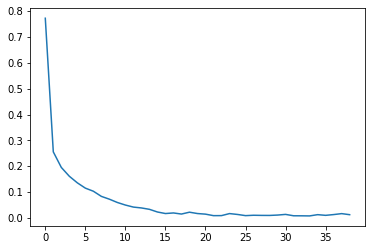

In [133]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)